In [244]:
from typing import Any
import random
import os

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from validation_model import ValidationModel
from settings import *
from avapix.avapix_loss import AvapixLoss
from avapix.avapix_model import AvapixModel
import avapix.avapix_utils as utils

In [4]:
DEVICE = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)

print (f'Using device: {DEVICE}')

Using device: cuda


In [269]:
def img_tensor_to_numpy(tensor: torch.Tensor):
    return tensor.detach().cpu().numpy().squeeze().transpose((1, 2, 0))

In [368]:
def show_model_output_image(tensor: torch.Tensor, title: str = ''):
    plt.imshow(img_tensor_to_numpy(tensor))
    plt.title(title)
    plt.show()

In [316]:
class EmbeddedFacesDataset(Dataset):
    def __init__(self, images, gen_per_image) -> None:
        super().__init__()

        self.transform = ToTensor()

        self.images = images.copy()
        self.gen_per_image = gen_per_image

        self.random_lengths = []
        self.curr_image_tensor = None

    def __getitem__(self, index) -> Any:
        if index % self.gen_per_image == 0:
            self.random_lengths = list(range(128))
            random.shuffle(self.random_lengths)

            curr_image = self.images[index // self.gen_per_image]
            self.curr_image_tensor = self.transform(
                Image.open(curr_image)).to(DEVICE)

        curr_rand_len = self.random_lengths.pop()

        output_img = utils.generate_input_v1(self.curr_image_tensor,
                                             DEFAULT_RANDOM_SEED,
                                             curr_rand_len)
        output_img = output_img.reshape((8, 8, 3)).permute((2, 0, 1))
        output_img /= 255

        return output_img

    def __len__(self):
        return len(self.images) * self.gen_per_image


In [352]:
class EmbeddedFacesDataset(Dataset):
    def __init__(self, num_samples) -> None:
        super().__init__()

        self.transform = ToTensor()

        self.num_samples = num_samples
        self.random_lengths = list(range(128))

    def __getitem__(self, index) -> Any:
        curr_rand_len = random.choice(self.random_lengths)

        curr_image_tensor = np.random.randint(0, 256, (8, 8, 3))
        curr_image_tensor = torch.tensor(curr_image_tensor, device=DEVICE, dtype=torch.float)
        output_img = utils.generate_input_v1(curr_image_tensor,
                                             DEFAULT_RANDOM_SEED,
                                             curr_rand_len)
        output_img = output_img.reshape((8, 8, 3)).permute((2, 0, 1))

        return output_img / 255

    def __len__(self):
        return self.num_samples


In [353]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils

In [357]:
LEARNING_RATE = 0.00005
BATCH_SIZE = 64
NUM_EPOCHS = 10
GEN_PER_IMAGE = 64

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

# dataset = EmbeddedFacesDataset(image_list, GEN_PER_IMAGE)
dataset = EmbeddedFacesDataset(50_000)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel()

criterion = AvapixLoss(0.000001)

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

In [370]:
losses = []

_ = 0
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    for batch_imgs in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_imgs)

        possibility_pred = loss_model(outputs)
        
        loss = criterion(possibility_pred)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    # for i, tensor_img in enumerate(outputs):
    #     img = img_tensor_to_numpy(tensor_img) * 255
    #     img = img.astype(np.uint8)
    #     Image.fromarray(img).save(f'./train_outputs/{_}_{i}.png')
    # _ += 1

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}")
    # if epoch % 10 == 9:
    #     print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS} - Loss: {avg_loss:.4f}", end='\t')
    #     if (epoch + 1) % 20 == 0:
    #         print()

print("Training complete.")

Epoch 001/10 - Loss: 2158.8130
Epoch 002/10 - Loss: 74883.3183
Epoch 003/10 - Loss: 37585.4624
Epoch 004/10 - Loss: 5430.1356
Epoch 005/10 - Loss: 3684.7533
Epoch 006/10 - Loss: 1715.9218
Epoch 007/10 - Loss: 679.5353
Epoch 008/10 - Loss: 140.1717
Epoch 009/10 - Loss: 158.5266
Epoch 010/10 - Loss: 65.5170
Training complete.


---

In [344]:
import importlib
import avapix.avapix_model
import avapix.avapix_loss
import avapix.avapix_utils
import validation_model
importlib.reload(avapix.avapix_model)
importlib.reload(avapix.avapix_loss)
importlib.reload(avapix.avapix_utils)
importlib.reload(validation_model)
from avapix.avapix_model import AvapixModel
from avapix.avapix_loss import AvapixLoss
import avapix.avapix_utils as utils
from validation_model import ValidationModel

LEARNING_RATE = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 100
GEN_PER_IMAGE = 10

image_list = os.listdir(VALID_FACE_DIR)
image_list = [os.path.join(VALID_FACE_DIR, img_file) for img_file in image_list]

dataset = EmbeddedFacesDataset(100000)
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=False)

model = AvapixModel()

criterion = AvapixLoss()

loss_model = ValidationModel()
loss_model.load_state_dict(torch.load('./assets/validation_model.pth'))

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE,
                             weight_decay=1e-4)

for batch_imgs in dataloader:
    outputs = model(batch_imgs)
    break

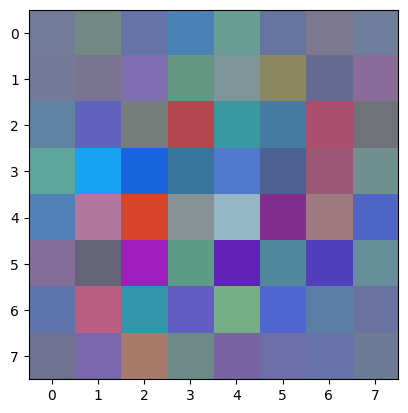

In [271]:
show_model_output_image(outputs[30])

In [231]:
loss = loss_model(outputs[30].to(DEVICE).unsqueeze(0))

In [233]:
criterion(loss)

tensor(155.7308, device='cuda:0', grad_fn=<MeanBackward0>)

---

In [375]:
_ = utils.embed_raw_img_v1('hello world!', 42).to(DEVICE) / 255
_ = _.reshape((3, 8, 8))
_ = _.unsqueeze(0)

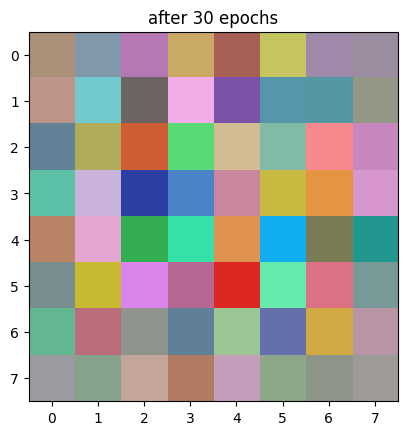

In [376]:
i_ = model(_)
show_model_output_image(i_, 'after 30 epochs')

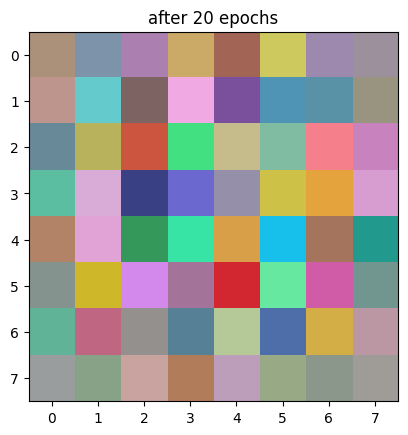

In [ ]:
i_ = model(_)
show_model_output_image(i_, 'after 20 epochs')